In [1]:
# ----- 2D FSI code demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, diags
from scipy.sparse.linalg import spsolve
import ast

In [2]:
# 配置文件处理器
# ============================
class ConfigHandler:
    def __init__(self, filename="control.dat"):
        self.params = {}
        with open(filename, 'r') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if line and not line.startswith('#'):
                    try:
                        key, value = line.split('=', 1)
                        value = value.split('#')[0].strip()
                        try:
                            parsed_value = ast.literal_eval(value)
                        except Exception:
                            parsed_value = value  # fallback: treat as string
                        self.params[key.strip()] = parsed_value
                    except Exception as e:
                        print(f"⚠️ 配置文件第 {line_num} 行格式错误: {line}")
                        print(f"   错误信息: {e}")

    def get(self, key, default=None):
        return self.params.get(key, default)

In [3]:
# test-------- 
if __name__ == "__main__":
    config = ConfigHandler("control.dat")
    
    print("✔️ 成功读取配置参数：")
    print(f"nx          = {config.get('nx')}")
    print(f"rho         = {config.get('rho')}")
    print(f"use_gravity = {config.get('use_gravity')}")
    print(f"name        = {config.get('name')}")
    print(f"values      = {config.get('values')}")
    
    # 测试默认值返回
    print(f"not_exist   = {config.get('missing_key', '默认值')}")


✔️ 成功读取配置参数：
nx          = 64
rho         = 1.0
use_gravity = True
name        = TestCase
values      = [1, 2, 3]
not_exist   = 默认值


In [4]:
# 非均匀网格生成器
# ============================
class GridGenerator:
    @staticmethod
    def generate_transition_refined_grid(n, L, refine_range=(0.3, 0.7),
                                         refine_percent=0.6, transition_percent_l=0.2, transition_percent_r=0.2):
        """
        更合理的加密网格生成方式：
        - 明确指定加密区物理范围
        - 加密区和过渡区网格数量按比例分配
        - 所有区域网格数之和为 n
        - 过渡区 dx 使用等比变化，粗到细再细到粗
        - 无单独“粗网格区”，其功能由过渡区完成

        参数：
            n: 总网格数
            L: 物理总长度
            refine_range: 加密区域物理位置 (x_start, x_end)
            refine_percent: 加密区网格占比 (例如 0.6)
            transition_percent_l: 左侧过渡区网格占比（例如 0.2）
            transition_percent_r: 右侧过渡区网格占比（例如 0.2）
        
        返回：
            x: 网格节点坐标（长度为 n）
            dx_min: 最小网格尺寸
            dx_max: 最大网格尺寸
            ratio: dx_max / dx_min
        """
        assert abs(refine_percent + transition_percent_l + transition_percent_r - 1.0) < 1e-6, "三个区域网格百分比之和必须为 1"
        
        x_start, x_end = refine_range
        refine_length = x_end - x_start
        assert 0 < x_start < x_end < L, "加密区必须位于物理区间 (0, L) 内"

        # 区域长度
        trans_len = x_start  # 左过渡区
        refine_len = x_end - x_start
        trans2_len = L - x_end  # 右过渡区

        # 每段网格数量
        n_refine = int(n * refine_percent)
        n_trans_l = int(n * transition_percent_l)
        n_trans_r = n - n_refine - n_trans_l  # 避免小数误差直接用剩下的

        # 每段 dx 最小网格尺寸
        dx_min = refine_len / n_refine

        # 计算过渡区的公比（假设等比数列的起始项和终止项分别为 dx_min 和 dx_max）
        # 根据物理长度和网格数，过渡区的最大网格尺寸 dx_max
        dx_max_l = trans_len / n_trans_l if n_trans_l > 1 else dx_min
        dx_max_r = trans2_len / n_trans_r if n_trans_r > 1 else dx_min

        # 选择最大网格尺寸作为公比的参考
        dx_max = max(dx_max_l, dx_max_r)
        ratio = dx_max / dx_min

        # 构建过渡区的网格（等比数列）
        # 左侧过渡区（从粗到细）
        if n_trans_l > 1:
            dx_trans_l = np.geomspace(dx_max_l, dx_min, n_trans_l)
        else:
            dx_trans_l = np.full(n_trans_l, dx_min)

        # 右侧过渡区（从细到粗）
        if n_trans_r > 1:
            dx_trans_r = np.geomspace(dx_min, dx_max_r, n_trans_r)
        else:
            dx_trans_r = np.full(n_trans_r, dx_min)

        # 加密区（均匀分布，网格大小 dx_min）
        dx_refine = np.full(n_refine, dx_min)

        # 拼接所有区域的 dx 数列
        dx_all = np.concatenate([dx_trans_l, dx_refine, dx_trans_r])
        x = np.cumsum(dx_all)
        x -= x[0]  # 归一化起始点
        x *= L / x[-1]  # 重新调整到 L

        return x, dx_min, dx_max, ratio

    @staticmethod
    def generate_2d_grid(nx, ny, Lx, Ly,
                         refine_x=(0.3, 0.7), refine_y=(0.2, 0.4),  
                         refine_percent=0.6, transition_percent_l=0.2, transition_percent_r=0.2):
        x, dx_min_x, dx_max_x, ratio_x = GridGenerator.generate_transition_refined_grid(
            nx, Lx, refine_x, refine_percent, transition_percent_l, transition_percent_r)
        y, dx_min_y, dx_max_y, ratio_y = GridGenerator.generate_transition_refined_grid(
            ny, Ly, refine_y, refine_percent, transition_percent_l, transition_percent_r)
        return x, y, (dx_min_x, dx_max_x, ratio_x), (dx_min_y, dx_max_y, ratio_y)

    @staticmethod
    def plot_grid(x, y):
        """可视化二维网格结构"""
        X, Y = np.meshgrid(x, y)
        plt.figure(figsize=(8, 4))
        for xi in x:
            plt.plot([xi] * len(y), y, color='gray', lw=0.5)
        for yi in y:
            plt.plot(x, [yi] * len(x), color='gray', lw=0.5)
        plt.title("Refined Grid with Geometric Transitions")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.axis('equal')
        plt.grid(False)
        plt.tight_layout()
        plt.show()






[X方向] dx_min = 0.0040, dx_max = 0.0223, ratio = 5.58
[Y方向] dx_min = 0.0083, dx_max = 0.0237, ratio = 2.84


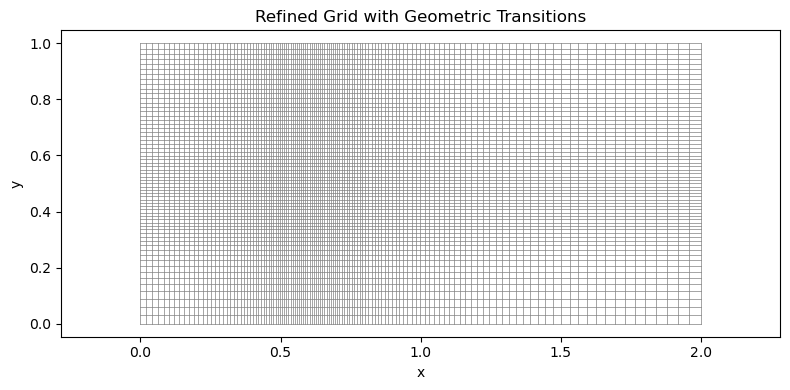

In [5]:
if __name__ == "__main__":
    # 生成2D网格
    x, y, info_x, info_y = GridGenerator.generate_2d_grid(
        nx=128, ny=64,               # X和Y方向的网格点数
        Lx=2.0, Ly=1.0,             # 物理长度（单位：米）
        refine_x=(0.45, 0.55),      # X方向加密区域物理位置（从 45% 到 55%）
        refine_y=(0.45, 0.55),      # Y方向加密区域物理位置（从 45% 到 55%）
        refine_percent=0.2,         # 加密区域占总网格的比例（20%）
        transition_percent_l=0.3,   # X方向左侧过渡区域占比（40%）
        transition_percent_r=0.5    # X方向右侧过渡区域占比（40%）
    )

    # 打印输出网格尺寸信息
    print(f"[X方向] dx_min = {info_x[0]:.4f}, dx_max = {info_x[1]:.4f}, ratio = {info_x[2]:.2f}")
    print(f"[Y方向] dx_min = {info_y[0]:.4f}, dx_max = {info_y[1]:.4f}, ratio = {info_y[2]:.2f}")

    # 可视化网格结构
    GridGenerator.plot_grid(x, y)






In [23]:
# 网格类
# ============================
class Grid:
    def __init__(self, config):
        self.config = config
        self.nx = config.get('nx', 64)
        self.ny = config.get('ny', 32)
        if config.get('grid_file', 0) == 1:
            self.load_from_file()
        else:
            self.generate_new_grid()
        self.initialize_mesh_metrics()

    def load_from_file(self):
        try:
            data = np.load('grid.dat', allow_pickle=True).item()
            self.xu, self.yu = data['xu'], data['yu']
            self.xv, self.yv = data['xv'], data['yv']
            self.xp, self.yp = data['xp'], data['yp']
        except FileNotFoundError:
            print("Grid file not found, generating new grid")
            self.generate_new_grid()

    def generate_new_grid(self):
        Lx = self.config.get('Lx', 4.0)
        Ly = self.config.get('Ly', 2.0)
        self.xu, self.yu = GridGenerator.generate_stretched_grid(self.nx, self.ny, Lx, Ly)
        self.xv, self.yv = self.xu.copy(), self.yu.copy()
        self.xp = 0.5 * (self.xu[1:] + self.xu[:-1])
        self.yp = 0.5 * (self.yu[1:] + self.yu[:-1])
        if self.config.get('grid_file', 0) == 1:
            self.save_grid()

    def save_grid(self):
        grid_data = {
            'xu': self.xu, 'yu': self.yu,
            'xv': self.xv, 'yv': self.yv,
            'xp': self.xp, 'yp': self.yp
        }
        np.save('grid.dat', grid_data)

    def initialize_mesh_metrics(self):
        self.dxu = np.diff(self.xu)
        self.dyu = np.diff(self.yu)
        self.dxv = np.diff(self.xv)
        self.dyv = np.diff(self.yv)
        self.vol = np.outer(self.dyu, self.dxu)

In [24]:
# 流场类
# ============================
class FlowField:
    def __init__(self, grid, config):
        self.config = config
        self.grid = grid
        self.rho = config.get('rho', 1.0)
        self.nu_artificial = config.get('nu_artificial', 0.01)

        self.u = np.zeros((len(grid.yu), len(grid.xu))) + config.get('U_inlet', 1.0)
        self.v = np.zeros((len(grid.yv), len(grid.xv)))
        self.p = np.zeros((len(grid.yp), len(grid.xp)))

    def apply_boundary_conditions(self):
        self.u[:, 0] = self.config.get('U_inlet', 1.0)
        self.v[:, 0] = 0.0
        self.u[:, -1] = self.u[:, -2]
        self.v[:, -1] = self.v[:, -2]
        self.p[:, -1] = 0.0
        self.v[0, :] = 0.0
        self.v[-1, :] = 0.0

In [33]:
# 浸入边界类
# ============================
class ImmersedBoundary:
    def __init__(self, config, grid):
        length = config.get('ib_length', 0.5)
        angle = np.deg2rad(config.get('ib_angle', 30))
        center = config.get('ib_center', [1.0, 1.0])
        
        n_points = config.get('ib_points', 20)
        s = np.linspace(-length/2, length/2, n_points)
        self.points = np.array([
            [center[0] + si*np.cos(angle), 
             center[1] + si*np.sin(angle)] 
            for si in s
        ])
        self.grid = grid
    
    def delta_function(self, r, h):
        """4点离散delta函数"""
        r_abs = np.abs(r/h)
        if r_abs <= 1:
            return (1 + np.cos(np.pi*r_abs)) / (4*h)
        return 0.0
    
    def interpolate_velocity(self, Xk, u, v):
        """速度插值到浸没边界点"""
        # 找到最近的网格索引
        i = np.searchsorted(self.grid.xu, Xk[0]) - 1
        j = np.searchsorted(self.grid.yu, Xk[1]) - 1
        
        # 双线性插值
        x_ratio = (Xk[0] - self.grid.xu[i]) / self.grid.dxu[i]
        y_ratio = (Xk[1] - self.grid.yu[j]) / self.grid.dyu[j]
        
        u_interp = (1-x_ratio)*(1-y_ratio)*u[j,i] + \
                   x_ratio*(1-y_ratio)*u[j,i+1] + \
                   (1-x_ratio)*y_ratio*u[j+1,i] + \
                   x_ratio*y_ratio*u[j+1,i+1]
        
        v_interp = (1-x_ratio)*(1-y_ratio)*v[j,i] + \
                   x_ratio*(1-y_ratio)*v[j,i+1] + \
                   (1-x_ratio)*y_ratio*v[j+1,i] + \
                   x_ratio*y_ratio*v[j+1,i+1]
        
        return np.array([u_interp, v_interp])
    
    def spread_force(self, Xk, Fk, fx, fy):
        for i in range(len(self.grid.xu)):
            if i >= len(self.grid.dxu):
                dx = self.grid.xu[i] - Xk[0]
                dxu_val = self.grid.dxu[-1]  # 取边界值
            else:
                dx = self.grid.xu[i] - Xk[0]
                dxu_val = self.grid.dxu[i]

            for j in range(len(self.grid.yu)):
                if j >= len(self.grid.dyu):
                    dy = self.grid.yu[j] - Xk[1]
                    dyu_val = self.grid.dyu[-1]
                else:
                    dy = self.grid.yu[j] - Xk[1]
                    dyu_val = self.grid.dyu[j]

                delta = self.delta_function(dx, dxu_val) * self.delta_function(dy, dyu_val)
                fx[j, i] += Fk[0] * delta * dxu_val * dyu_val
                fy[j, i] += Fk[1] * delta * dxu_val * dyu_val
        return fx, fy


In [26]:
# 多网格求解器类
# ============================
class MultiGridSolver:
    def __init__(self, grid, levels=3):
        self.grid = grid
        self.levels = levels
        self.initialize_operators()

    def initialize_operators(self):
        self.A_levels = []
        self.R_levels = []
        self.P_levels = []

        for l in range(self.levels):
            nx = self.grid.nx // (2**l)
            ny = self.grid.ny // (2**l)
            self.A_levels.append(self.build_poisson_matrix(nx, ny))

            if l < self.levels - 1:
                nxc = nx // 2
                nyc = ny // 2
                self.R_levels.append(self.build_identity(nyc, nxc, nx, ny))
                self.P_levels.append(self.build_identity(nx, ny, nxc, nyc))

    def build_identity(self, nx_to, ny_to, nx_from, ny_from):
        N_from = nx_from * ny_from
        N_to = nx_to * ny_to
        I = lil_matrix((N_to, N_from))
        for i in range(min(N_to, N_from)):
            I[i, i] = 1.0
        return I.tocsr()

    def V_cycle(self, b, x0, level=0):
        if level == self.levels - 1:
            return spsolve(self.A_levels[level], b)

        x = self.gauss_seidel(self.A_levels[level], b, x0, iterations=2)
        residual = b - self.A_levels[level].dot(x)
        b_coarse = self.R_levels[level].dot(residual)
        e_coarse = self.V_cycle(b_coarse, np.zeros_like(b_coarse), level + 1)
        x += self.P_levels[level].dot(e_coarse)
        x = self.gauss_seidel(self.A_levels[level], b, x, iterations=2)
        return x

    def build_poisson_matrix(self, nx, ny):
        A = lil_matrix((nx * ny, nx * ny))
        for j in range(ny):
            for i in range(nx):
                row = j * nx + i
                A[row, row] = -4.0
                if i > 0: A[row, row - 1] = 1.0
                if i < nx - 1: A[row, row + 1] = 1.0
                if j > 0: A[row, row - nx] = 1.0
                if j < ny - 1: A[row, row + nx] = 1.0
        return A.tocsr()

    def gauss_seidel(self, A, b, x, iterations):
        for _ in range(iterations):
            for i in range(A.shape[0]):
                row_start = A.indptr[i]
                row_end = A.indptr[i + 1]
                Ax = sum(A.data[row_start:row_end] * x[A.indices[row_start:row_end]])
                x[i] = (b[i] - (Ax - A[i, i] * x[i])) / A[i, i]
        return x

In [36]:
# FSI求解器主类
# ============================
class FSISolver:
    def __init__(self, config):
        self.config = config
        self.grid = Grid(config)
        self.field = FlowField(self.grid, config)
        self.ib = ImmersedBoundary(config, self.grid)
        self.mg_solver = MultiGridSolver(self.grid, config.get('mg_levels', 3))
        
        self.dt = config.get('dt', 0.005)
        self.steps = config.get('steps', 100)
    
    def second_order_upwind(self, phi, idx, delta, direction):
        if direction > 0:
            if idx < 2:
            # 使用一阶迎风或中心差分替代
                return (phi[idx] - phi[idx-1]) / delta if idx > 0 else 0.0
            return (3*phi[idx] - 4*phi[idx-1] + phi[idx-2]) / (2*delta)
        else:
            if idx > len(phi) - 3:
            # 使用一阶迎风或中心差分替代
                return (phi[idx+1] - phi[idx]) / delta if idx < len(phi) - 1 else 0.0
            return (-phi[idx+2] + 4*phi[idx+1] - 3*phi[idx]) / (2*delta)

    
    def solve_momentum(self):
        """求解动量方程（含人工粘性）"""
        nu = self.field.nu_artificial
        u, v = self.field.u, self.field.v
        
        u_star = u.copy()
        v_star = v.copy()
        
        for j in range(1, self.grid.ny-1):
            for i in range(1, self.grid.nx-1):
                # 对流项（二阶迎风）
                du_dx = self.second_order_upwind(u[j,:], i, 
                    self.grid.dxu[i], u[j,i])
                du_dy = self.second_order_upwind(u[:,i], j,
                    self.grid.dyu[j], v[j,i])
                
                # 扩散项（人工粘性）
                diffusion = nu * (
                    (u[j,i+1] - 2*u[j,i] + u[j,i-1])/self.grid.dxu[i]**2 +
                    (u[j+1,i] - 2*u[j,i] + u[j-1,i])/self.grid.dyu[j]**2
                )
                
                u_star[j,i] = u[j,i] + self.dt * (
                    -u[j,i]*du_dx - v[j,i]*du_dy + diffusion
                )
        
        return u_star, v_star
    
    def solve_pressure(self, u_star, v_star):
        # 构建源项
        div_u = np.zeros_like(self.field.p)
        for j in range(1, self.grid.ny-1):
            for i in range(1, self.grid.nx-1):
                div_u[j,i] = (u_star[j,i+1] - u_star[j,i-1])/(2*self.grid.dxu[i]) + \
                             (v_star[j+1,i] - v_star[j-1,i])/(2*self.grid.dyu[j])
        
        # 调用多网格求解器
        p_corr = self.mg_solver.V_cycle(
            div_u.flatten()/self.dt,
            self.field.p.flatten()
        ).reshape(self.field.p.shape)
        
        return p_corr
    
    def correct_velocity(self, u_star, v_star, p_corr):
        """速度修正"""
        u = u_star.copy()
        v = v_star.copy()
        
        for j in range(1, self.grid.ny-1):
            for i in range(1, self.grid.nx-1):
                dpdx = (p_corr[j,i+1] - p_corr[j,i-1])/(2*self.grid.dxu[i])
                dpdy = (p_corr[j+1,i] - p_corr[j-1,i])/(2*self.grid.dyu[j])
                
                u[j,i] -= self.dt/self.field.rho * dpdx
                v[j,i] -= self.dt/self.field.rho * dpdy
        
        return u, v
    
    def run(self):
        """主求解循环"""
        for step in range(self.steps):
            print(f"Step {step+1}/{self.steps}")
            
            # 1. 计算浸没边界力
            fx = np.zeros_like(self.field.u)
            fy = np.zeros_like(self.field.v)
            for Xk in self.ib.points:
                Uk = self.ib.interpolate_velocity(Xk, self.field.u, self.field.v)
                Fk = (np.zeros(2) - Uk) * self.field.rho / self.dt
                fx, fy = self.ib.spread_force(Xk, Fk, fx, fy)
            
            # 2. 求解动量方程
            u_star, v_star = self.solve_momentum()
            
            # 3. 求解压力
            p_corr = self.solve_pressure(u_star, v_star)
            
            # 4. 修正速度压力场
            self.field.u, self.field.v = self.correct_velocity(u_star, v_star, p_corr)
            self.field.p += p_corr
            
            # 5. 应用边界条件
            self.field.apply_boundary_conditions()
    
    def visualize(self):
        """结果可视化"""
        plt.figure(figsize=(12,6))
        plt.contourf(self.grid.xp, self.grid.yp, self.field.p, levels=20, cmap='RdBu')
        plt.colorbar(label='Pressure')
        plt.quiver(self.grid.xu, self.grid.yu, self.field.u, self.field.v, scale=30)
        plt.scatter(self.ib.points[:,0], self.ib.points[:,1], c='red', s=20)
        plt.title('FSI Simulation with Immersed Boundary')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [37]:

# 主程序
# ============================
if __name__ == "__main__":
    config = ConfigHandler("control.dat")
    solver = FSISolver(config)
    solver.run()
    solver.visualize()

Step 1/100


IndexError: index 1953 is out of bounds for axis 0 with size 1953